In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import glob
from pathlib import Path
import os
from omegaconf import OmegaConf
from pprint import pprint as pp
from icecream import ic
from typing import List
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from EvalCV import *


In [2]:
project = Path().resolve().parent
configs = Path(project) / "config"
data_paths = OmegaConf.load(configs / "data.yaml")
print(OmegaConf.to_yaml(data_paths))
data_int = Path(data_paths.processed) / "modsec_audit_train_v1_prepared.parquet"
df = pd.read_parquet(data_int)

raw: ../data/raw
interim: ../data/interim
processed: ../data/processed



In [3]:
df

,layer_type,method,local_port,remote_port,req_content_length,resp_content_length,resp_vary,status_code,target,content_length_ratio,large_req,large_resp
0,SINGLE_LAYERED,OPTIONS,80,39486,0,0,"Access-Control-Request-Method, Access-Control-...",204,ssrf,0.000000,0,0
1,SINGLE_LAYERED,POST,80,39486,50,62,Origin,401,ssrf,1.240000,0,0
2,SINGLE_LAYERED,OPTIONS,80,39486,0,0,"Access-Control-Request-Method, Access-Control-...",204,ssrf,0.000000,0,0
3,SINGLE_LAYERED,POST,80,39486,57,33,Origin,200,ssrf,0.578947,0,0
4,SINGLE_LAYERED,GET,80,39486,0,8846,Origin,200,ssrf,0.000000,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
20003,Unknown,POST,1234,47098,57,62,Origin,401,Unknown,1.087719,0,0
20004,SINGLE_LAYERED,POST,1234,58032,72,64,Origin,403,sql_injection,0.888889,0,1
20005,SINGLE_LAYERED,POST,1234,39592,74,33,Origin,200,sql_injection,0.445946,0,0
20006,SINGLE_LAYERED,POST,1234,39592,74,33,Origin,200,sql_injection,0.445946,0,0


# Data Modeling

In [4]:
pp(models)

[(LogisticRegression(class_weight='balanced', max_iter=1000), 'lr_clf'),
 (SVC(class_weight='balanced'), 'svm_rbf_clf'),
 (KNeighborsClassifier(n_neighbors=3), 'knn3_clf'),
 (KNeighborsClassifier(), 'knn5_clf'),
 (KNeighborsClassifier(n_neighbors=7), 'knn7_clf'),
 (GaussianNB(), 'gnb_clf'),
 (DecisionTreeClassifier(class_weight='balanced'), 'dt_clf'),
 (RandomForestClassifier(class_weight='balanced', n_jobs=-1), 'rfc_clf'),
 (ExtraTreesClassifier(class_weight='balanced', n_jobs=-1), 'etc_clf'),
 (GradientBoostingClassifier(), 'gbc_clf'),
 (HistGradientBoostingClassifier(class_weight='balanced'), 'hgb_clf'),
 (XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=N

In [5]:
target2enc = {
    "Unknown": 0,
    "ssrf": 1,
    "xss": 2,
    "sql_injection":3
}

enc2target = {v: k for k, v in target2enc.items()}

In [6]:
target2enc, enc2target

({'Unknown': 0, 'ssrf': 1, 'xss': 2, 'sql_injection': 3},
 {0: 'Unknown', 1: 'ssrf', 2: 'xss', 3: 'sql_injection'})

In [7]:
num_cols = list(df.select_dtypes(include=np.number).columns)
cat_cols = list(df.select_dtypes(exclude=np.number).columns)
target = cat_cols.pop()
X = df[num_cols + cat_cols]
y = df[target].map(target2enc).astype(int)

In [8]:
df_results = evaluate_models(X, y, models=models, num_cols=num_cols, cat_cols=cat_cols, n_splits=5)

Evaluating models:   0%|          | 0/12 [00:00<?, ?it/s]


=== Model: lr_clf ===
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.98      0.92        66
           1       1.00      0.96      0.98     19842
           2       0.12      0.81      0.21        26
           3       0.09      0.89      0.16        74

    accuracy                           0.96     20008
   macro avg       0.52      0.91      0.57     20008
weighted avg       0.99      0.96      0.97     20008

Confusion Matrix:
[[   65     0     0     1]
 [   11 18991   149   691]
 [    0     4    21     1]
 [    0     4     4    66]]

=== Model: svm_rbf_clf ===
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        66
           1       1.00      0.98      0.99     19842
           2       0.66      0.81      0.72        26
           3       0.18      0.95      0.30        74

    accuracy                           0.98     20008
   macro avg   

In [9]:
df_results.to_parquet("../data/results/model_eval_results.parquet")
df_results.to_csv("../data/results/model_eval_results.csv", index=False)
df_results

,model,accuracy_mean,accuracy_std,f1_mean,f1_std,precision_mean,precision_std,recall_mean,recall_std
0,lr_clf,0.956767,0.006536,0.568818,0.025929,0.522066,0.033735,0.910193,0.057048
1,svm_rbf_clf,0.982857,0.002453,0.750392,0.044131,0.723970,0.051409,0.926256,0.052654
2,knn3_clf,0.997951,0.000678,0.872935,0.045475,0.930114,0.035295,0.840088,0.070294
3,knn5_clf,0.997801,0.000696,0.848441,0.049966,0.910111,0.066325,0.811517,0.058860
4,knn7_clf,0.997651,0.000700,0.827542,0.060130,0.913449,0.085194,0.779637,0.053184
5,gnb_clf,0.035934,0.034503,0.279938,0.016844,0.507863,0.001484,0.626905,0.031904
6,dt_clf,0.998900,0.000374,0.922396,0.021208,0.939187,0.034124,0.919436,0.034940
7,rfc_clf,0.998900,0.000464,0.927536,0.041674,0.977142,0.029158,0.901165,0.069147
8,etc_clf,0.998800,0.000367,0.919421,0.039902,0.964357,0.038133,0.894235,0.057094
9,gbc_clf,0.997751,0.001214,0.857071,0.056331,0.922964,0.031789,0.831859,0.064182


# Make Visualization

In [10]:
import seaborn as sns
from math import pi

# Single-metric bar plot helper
def plot_metric(data, metric, color, title, ylabel, ylim_bottom=0):
    plt.figure(figsize=(12, 8))
    plt.bar(data["model"], data[metric], color=color)
    plt.xticks(rotation=45, ha='right')
    plt.xlabel("Model")
    plt.ylabel(ylabel)
    plt.ylim(bottom=ylim_bottom)
    plt.title(title)
    for idx, val in enumerate(data[metric]):
        plt.text(idx, val, f"{val:.2f}", ha='center', va='bottom')
    plt.tight_layout()
    plt.show()

# Plot F1, Precision, Recall
def plot(df, ylim=0):
    plot_metric(df, "accuracy_mean", "blue", "Mean Accuracy Score per Model", "Mean Accuracy Score", ylim)
    plot_metric(df, "f1_mean", "green", "Mean F1 Score per Model", "Mean F1 Score", ylim)
    plot_metric(df, "precision_mean", "orange", "Mean Precision per Model", "Mean Precision", ylim)
    plot_metric(df, "recall_mean", "purple", "Mean Recall per Model", "Mean Recall", ylim)

# Grouped bar chart for multiple metrics
def grouped_bar_chart(data, metrics, colors):
    bar_width = 0.2
    idx = np.arange(len(data))
    plt.figure(figsize=(14, 8))
    for i, metric in enumerate(metrics):
        plt.bar(idx + i*bar_width, data[metric], bar_width, label=metric, color=colors[i])
    plt.xlabel("Model")
    plt.ylabel("Score")
    plt.title("Model Performance by Metric")
    plt.xticks(idx + bar_width*(len(metrics)-1)/2, data["model"], rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Stacked bar chart
def stacked_bar_chart(data, metrics, colors):
    plt.figure(figsize=(14, 8))
    bottom = np.zeros(len(data))
    for metric, color in zip(metrics, colors):
        plt.bar(data["model"], data[metric], bottom=bottom, label=metric, color=color)
        bottom += data[metric]
    plt.xlabel("Model")
    plt.ylabel("Cumulative Score")
    plt.title("Cumulative Model Performance by Metric")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Radar chart function
def radar_chart(data, metrics):
    labels = metrics
    num_vars = len(labels)
    angles = [n/float(num_vars)*2*pi for n in range(num_vars)] + [0]
    plt.figure(figsize=(10, 10))
    for _, row in data.iterrows():
        values = [row[m] for m in metrics] + [row[metrics[0]]]
        plt.polar(angles, values, label=row["model"])
        plt.fill(angles, values, alpha=0.1)
    plt.xticks(angles[:-1], labels)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.title("Model Performance Radar Chart")
    plt.show()

# Improved radar chart for top N models
def highly_readable_radar_chart(data, metrics, max_models=5):
    agg = data[metrics].sum(axis=1)
    top_idx = np.argsort(agg)[-max_models:][::-1]
    selected = data.iloc[top_idx].reset_index(drop=True)
    num_vars = len(metrics)
    angles = [n/float(num_vars)*2*pi for n in range(num_vars)] + [0]
    cmap = plt.get_cmap('tab10', len(selected))
    plt.figure(figsize=(10, 10))
    for i, row in selected.iterrows():
        values = [row[m] for m in metrics] + [row[metrics[0]]]
        plt.polar(angles, values, label=row["model"], color=cmap(i), linewidth=2)
        plt.fill(angles, values, alpha=0.1, color=cmap(i))
    plt.xticks(angles[:-1], metrics)
    plt.yticks([0.2,0.4,0.6,0.8,1.0], ["0.2","0.4","0.6","0.8","1.0"])
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.title(f"Top {max_models} Models Radar Chart")
    plt.show()

# Heatmap
def heatmap(data, metrics):
    plt.figure(figsize=(12, 8))
    sns.heatmap(data.set_index('model')[metrics], annot=True, cmap="YlGnBu")
    plt.title("Model Performance Metrics Heatmap")
    plt.xlabel("Metrics")
    plt.ylabel("Model")
    plt.tight_layout()
    plt.show()

In [11]:
# Metrics list and colors
metrics = ['accuracy_mean', 'f1_mean', 'precision_mean', 'recall_mean']
colors = ['blue', 'green', 'orange', 'purple']

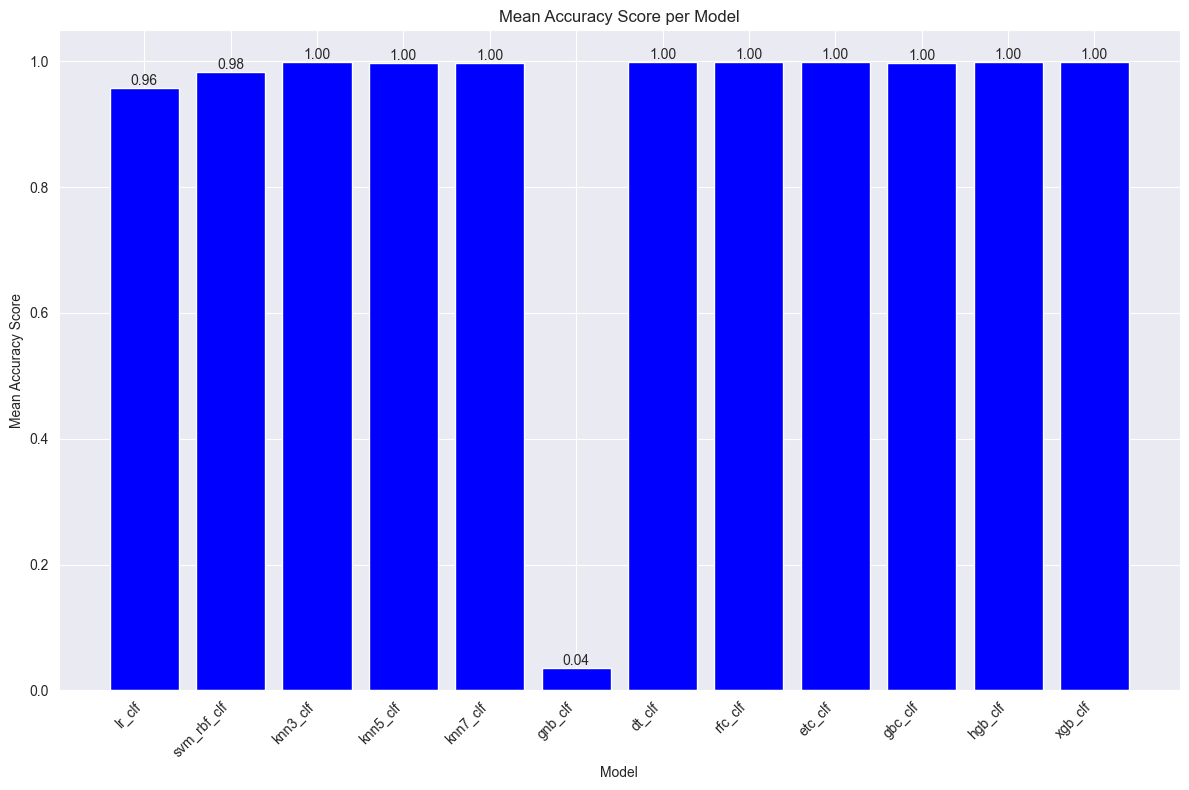

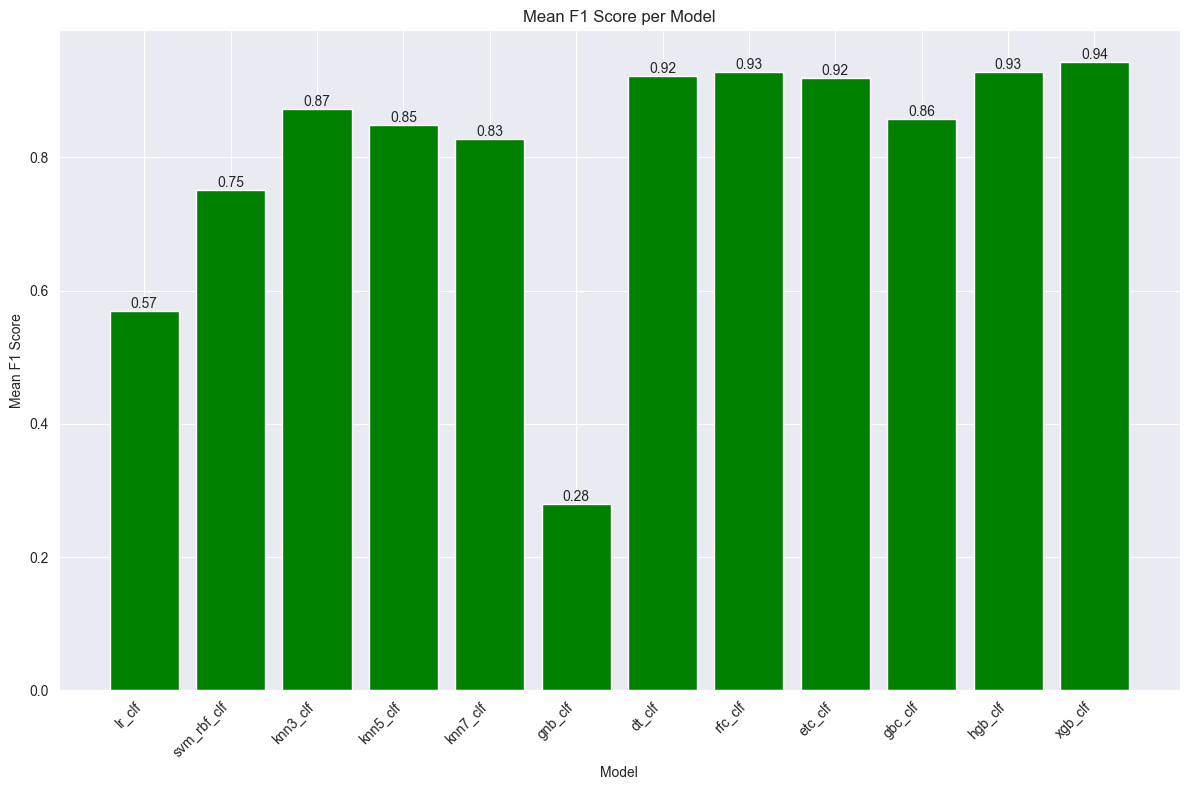

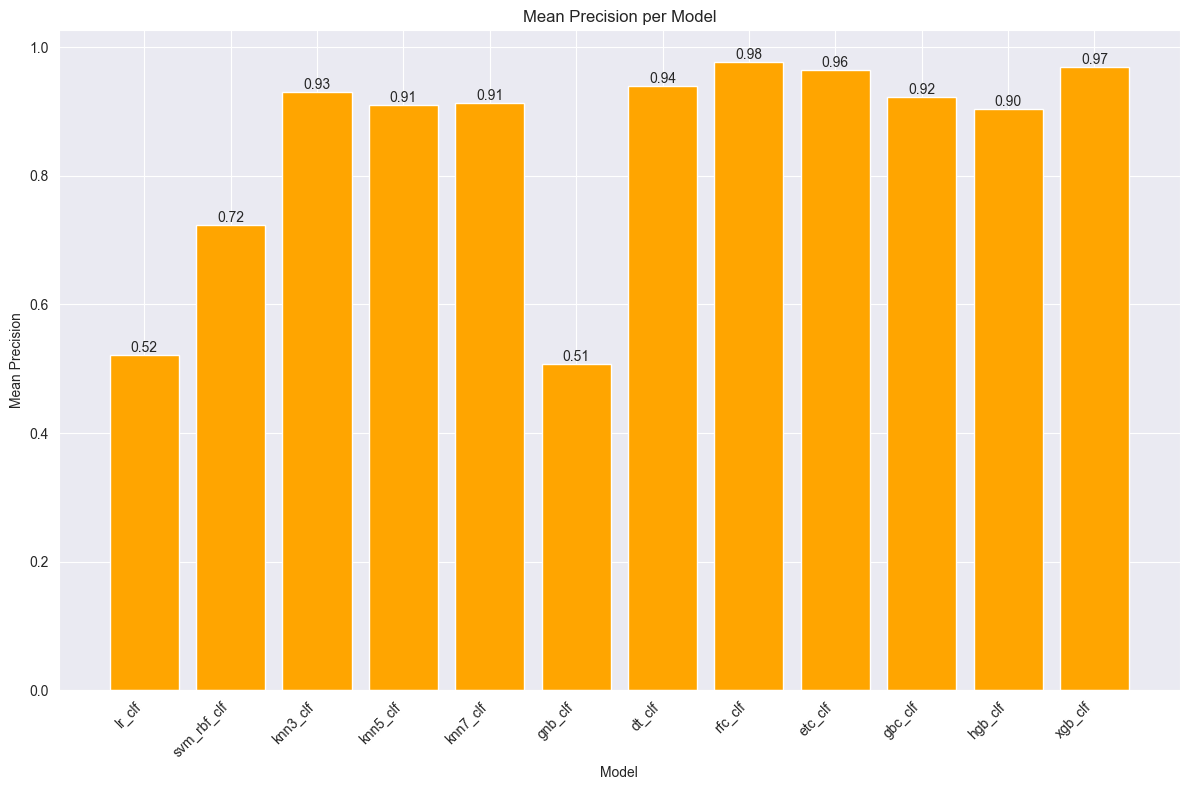

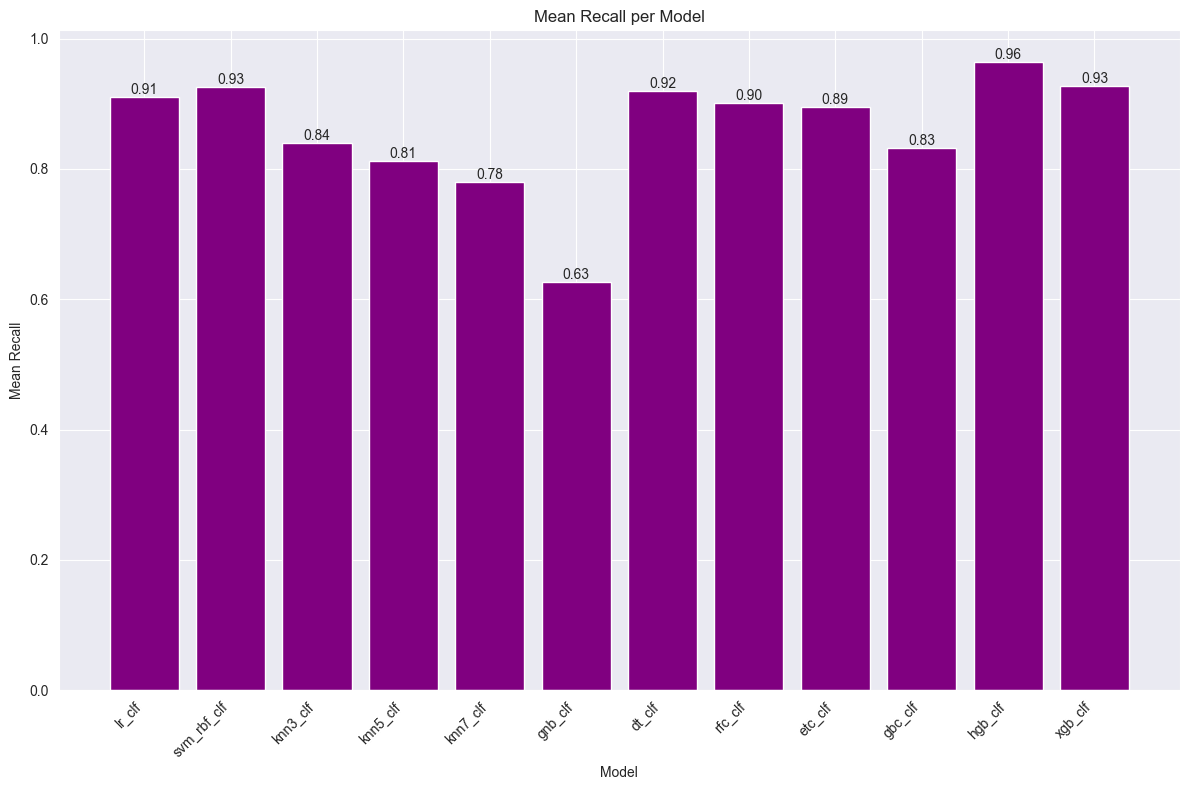

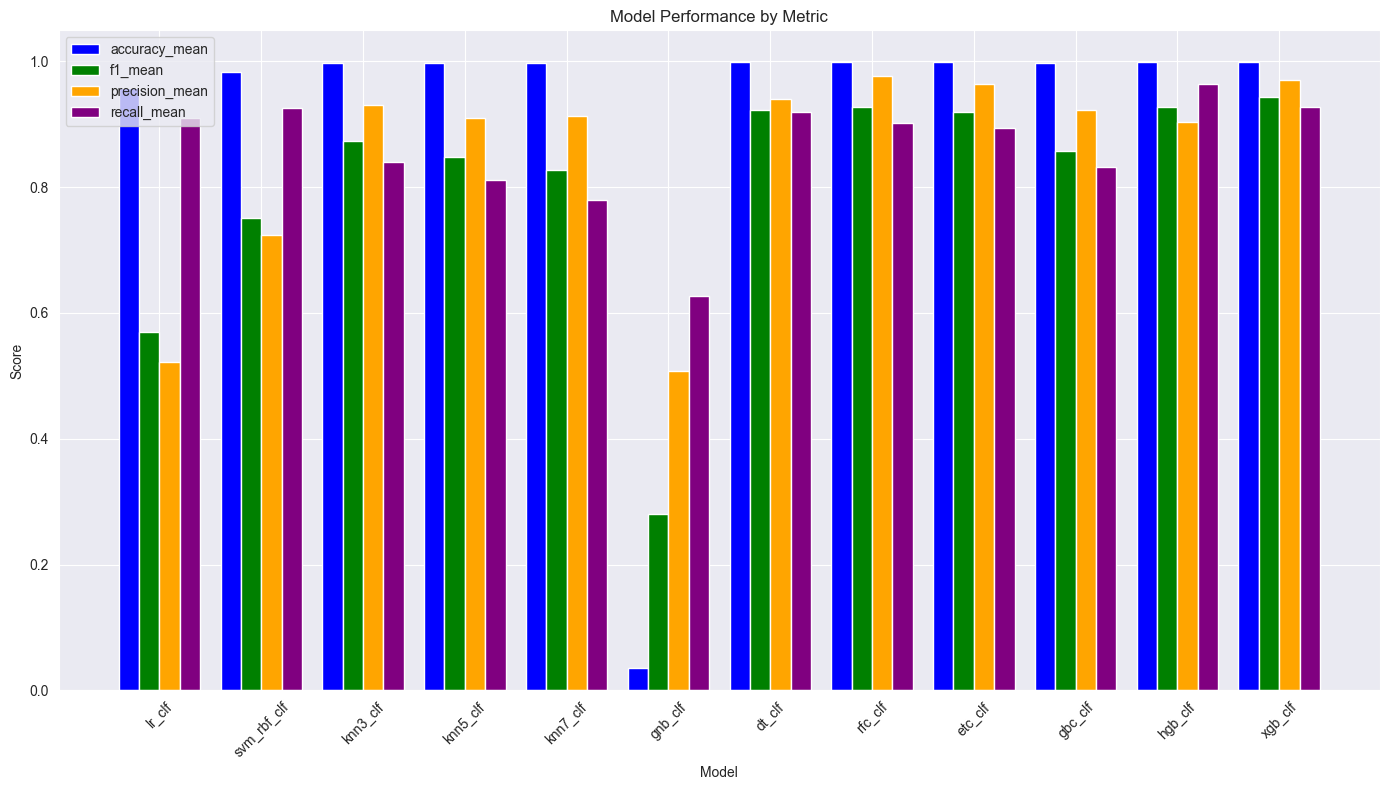

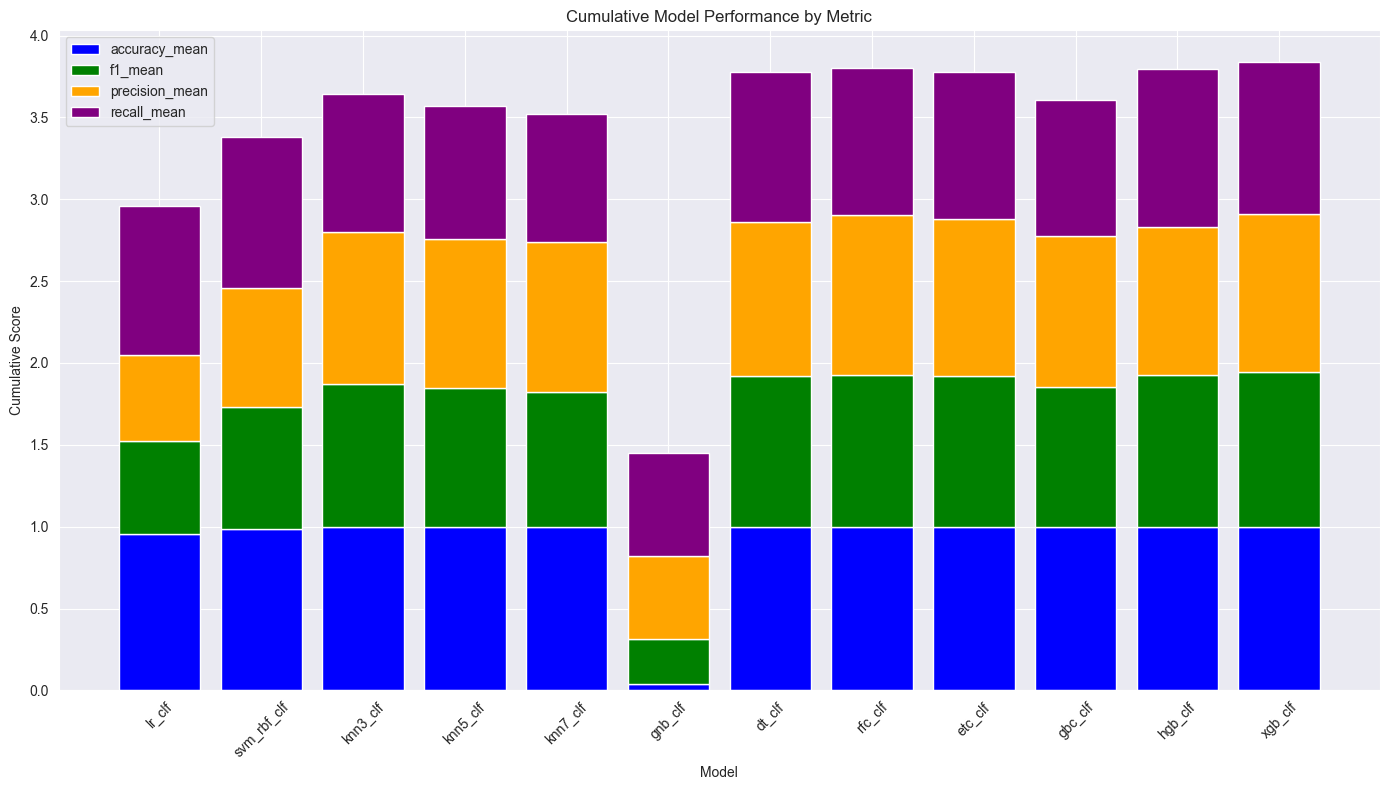

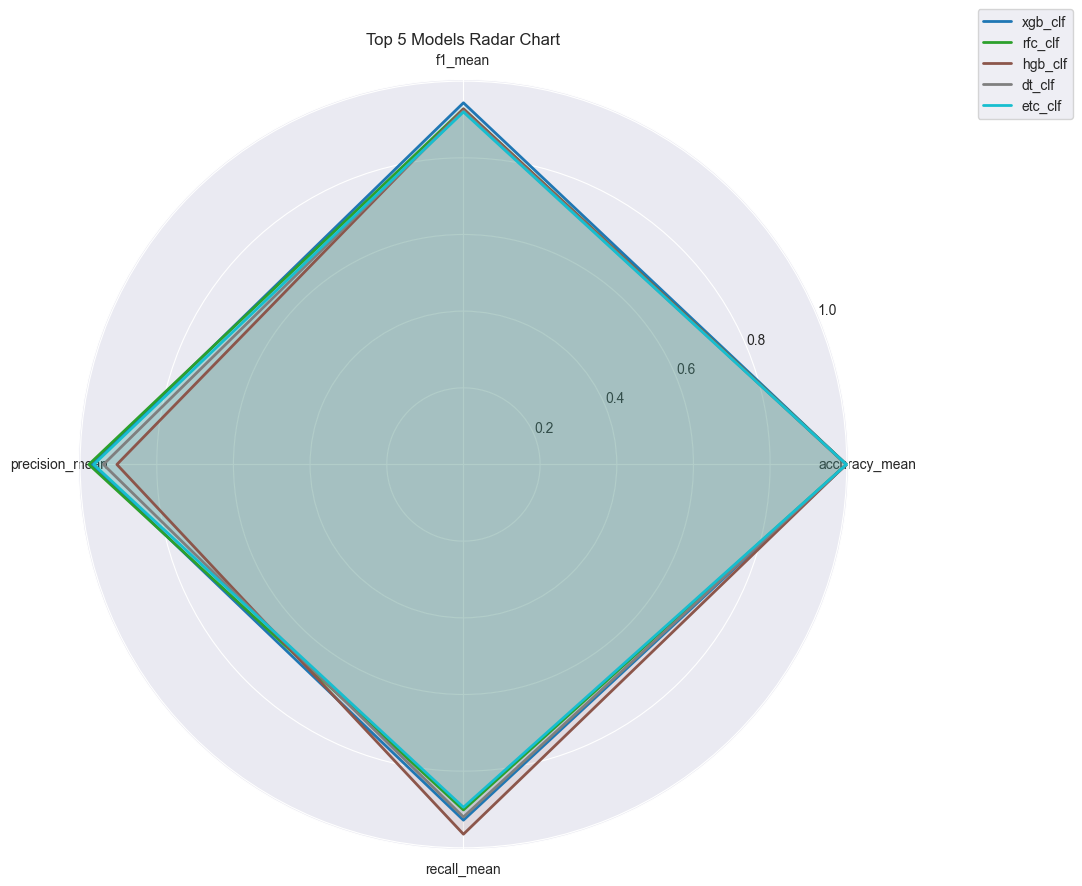

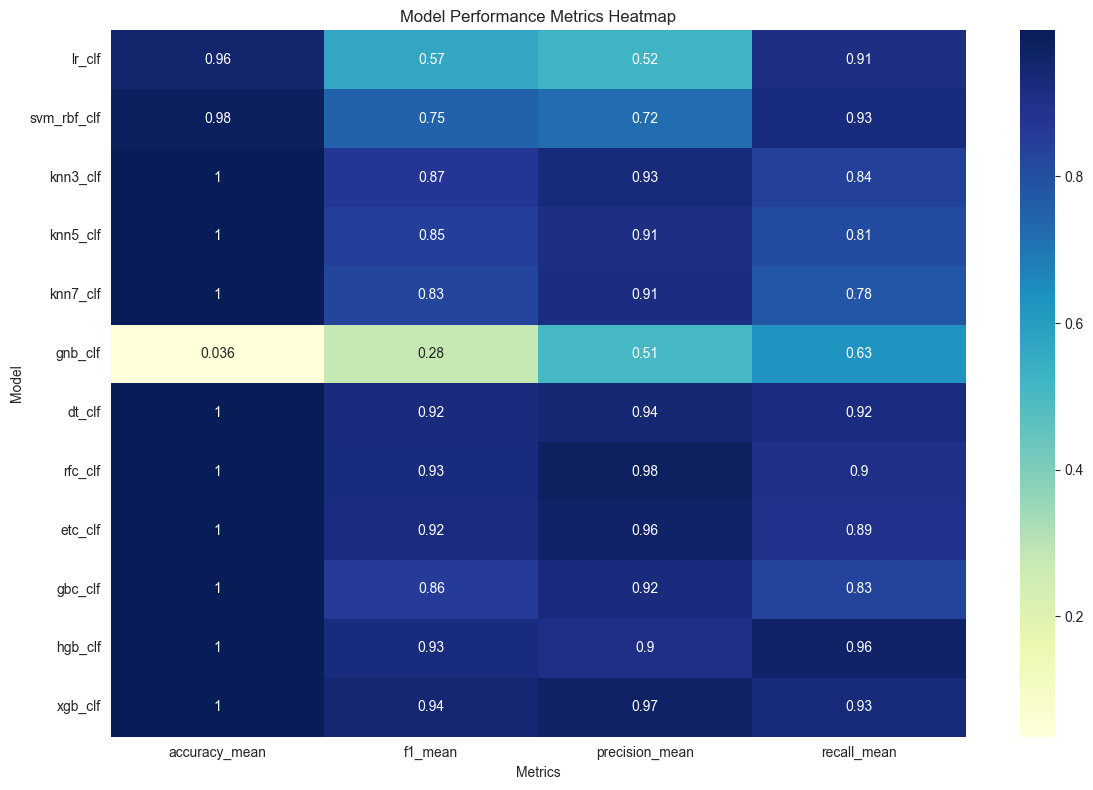

In [12]:
plot(df_results)

# 2. Grouped bar chart
grouped_bar_chart(df_results, metrics, colors)

# 3. Stacked bar chart
stacked_bar_chart(df_results, metrics, colors)

# 4. Radar chart (top 5 models)
highly_readable_radar_chart(df_results, metrics, max_models=5)

# 5. Heatmap
heatmap(df_results, metrics)